# Arxiv Dataset Clustering
This notebook aims to cluster scholarly articles from the Arxiv dataset.

# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns


## Load and Preview Data

In [2]:
input_file = '../data/data_preprocessed.csv'
df = pd.read_csv(input_file)
print(df.shape[0])
df.head()

1037103


,update_date,text,categories_list,num_categories
0,2022-03-31,convergence discrete dipole approximation theo...,"['physics.optics', 'physics.comp-ph']",2
1,2022-03-30,discrete dipole approximation overview develop...,"['physics.optics', 'physics.comp-ph']",2
2,2021-10-15,mapping radius metric space every closed curve...,['math.MG'],1
3,2019-08-19,remnant evolution carbon oxygen white dwarf me...,['astro-ph'],1
4,2019-08-19,cofibrations category frolicher space cofibrat...,['math.AT'],1


## Text Vectorization

In [3]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,   # Limit the number of features
    stop_words='english', # Remove common English stop words
    sublinear_tf=True     # Apply sublinear scaling
)

# Fit and transform the text data to a TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])

In [4]:
# Show top 50 features (unigrams and bigrams)
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
sorted_indices = np.argsort(tfidf_vectorizer.idf_)
top_features = feature_names[sorted_indices[:50]]
top_features_df = pd.DataFrame(top_features, columns=['Top 50 Features'])
print(top_features_df)

   Top 50 Features
0           result
1             data
2            model
3            field
4          network
5         learning
6         analysis
7           method
8            space
9        algorithm
10          energy
11        property
12     information
13      experiment
14         dynamic
15    distribution
16     application
17     dimensional
18        equation
19           level
20         quantum
21           class
22          linear
23       parameter
24        existing
25        compared
26          neural
27            rate
28            term
29     interaction
30           image
31           multi
32            deep
33           small
34        training
35         density
36          design
37           local
38        function
39         complex
40       condition
41          source
42         problem
43        observed
44            mass
45         feature
46     measurement
47        accuracy
48           state
49        standard


## Dimensionality Reduction

In [5]:
# Apply PCA
pca = PCA(n_components=150)  # Choose the number of components
pca_matrix = pca.fit_transform(tfidf_matrix.toarray())

## Determine Optimal Clusters

d:\ML-trend-analysis\Scientific-Trend-Analysis\env\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\ML-trend-analysis\Scientific-Trend-Analysis\env\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


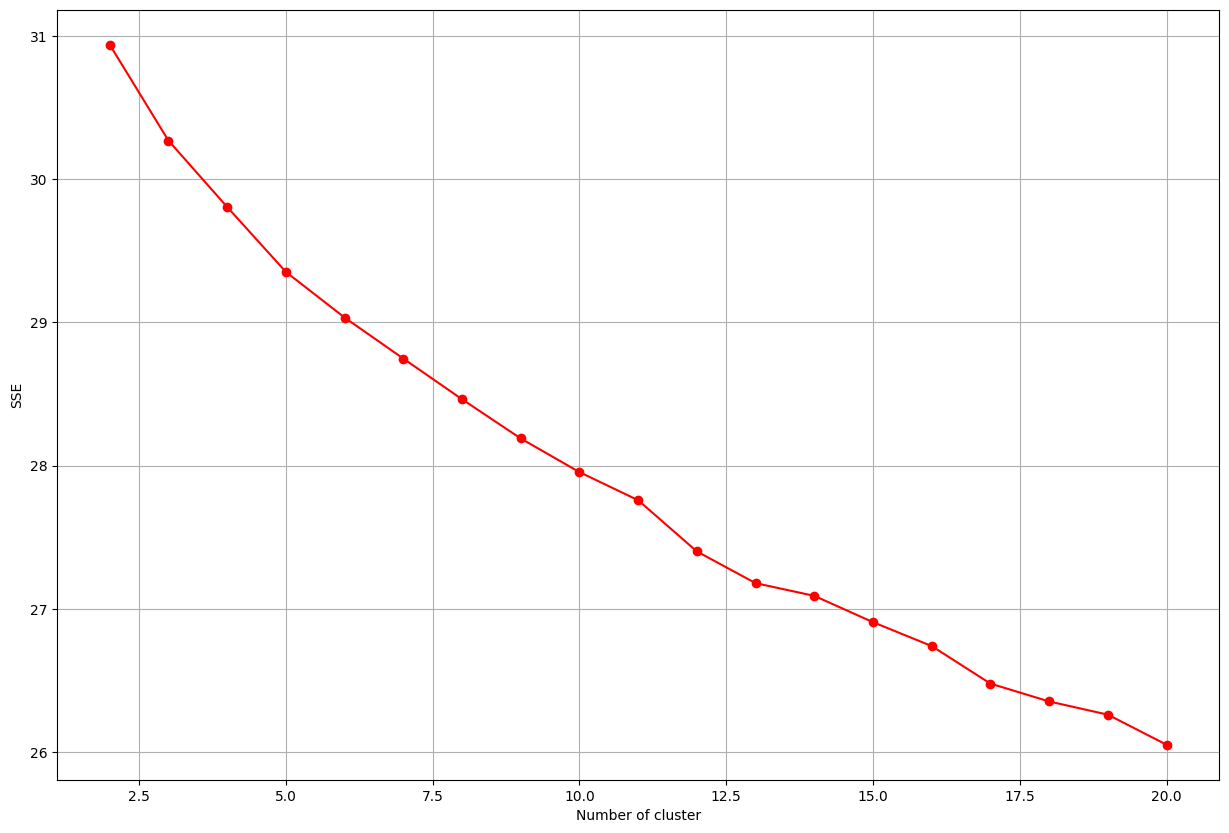

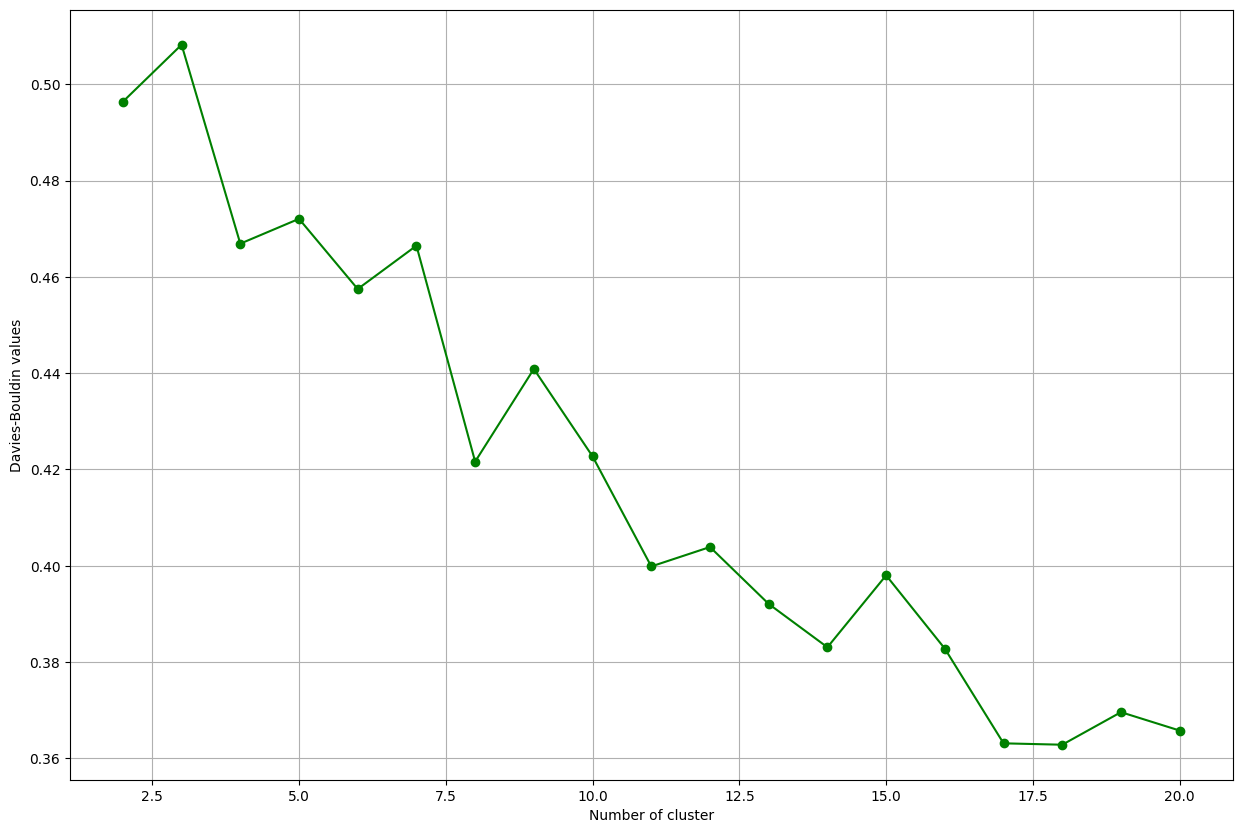

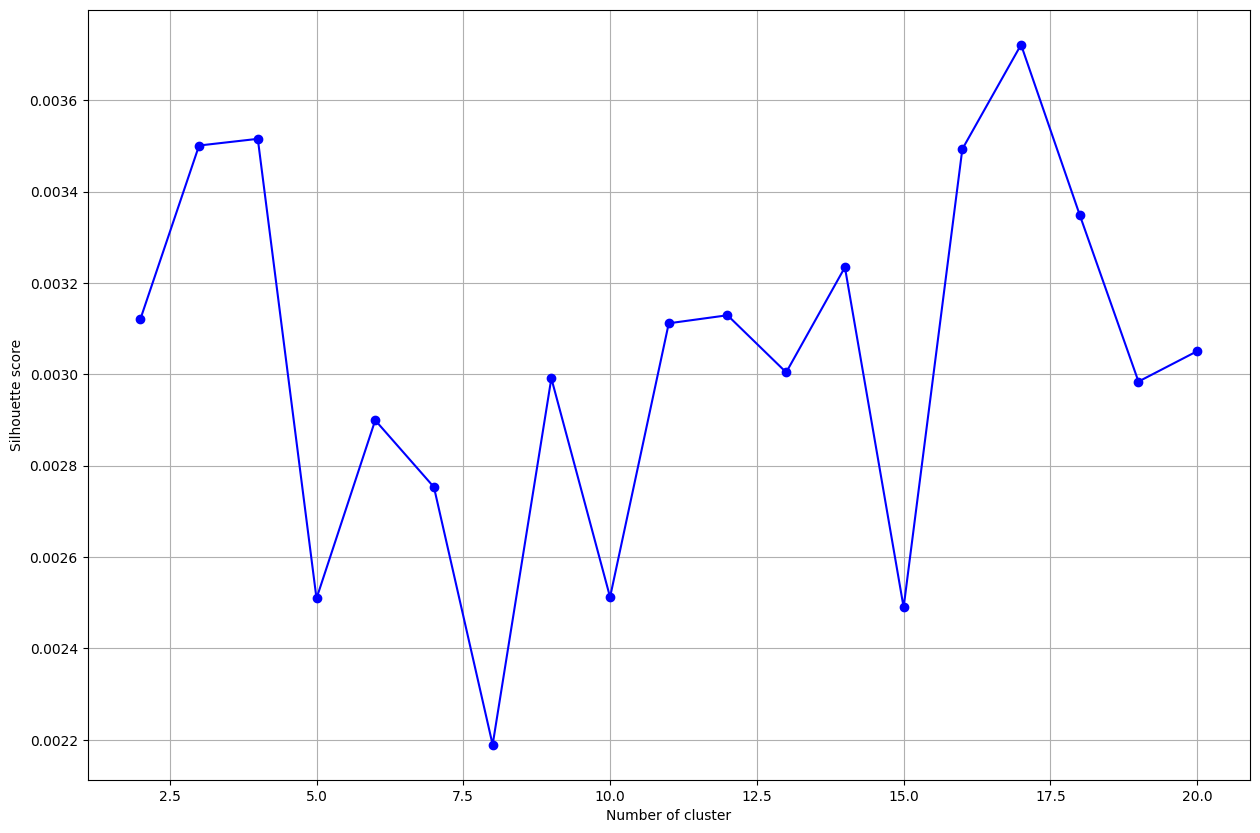

In [6]:
def check_clustering(X, K, n_runs=10):
    avg_sse, avg_db, avg_slc = {}, {}, {}
    
    for _ in range(n_runs):
        np.random.seed(42)  # Setting random seed for reproducibility
        sample_indices = np.random.choice(X.shape[0], int(0.001 * X.shape[0]), replace=False)
        X_sample = X[sample_indices]
        
        sse, db, slc = {}, {}, {}
        for k in range(2, K):
            kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=42, n_init=10).fit(X_sample)
            clusters = kmeans.labels_
            
            sse[k] = sse.get(k, 0) + kmeans.inertia_
            db[k] = db.get(k, 0) + davies_bouldin_score(X_sample, clusters)
            slc[k] = slc.get(k, 0) + silhouette_score(X_sample, clusters)
            
        for k in range(2, K):
            avg_sse[k] = sse[k] / n_runs
            avg_db[k] = db[k] / n_runs
            avg_slc[k] = slc[k] / n_runs


    plt.figure(figsize=(15,10))
    plt.plot(list(avg_sse.keys()), list(avg_sse.values()), marker='o', linestyle='-', color='r')
    plt.xlabel("Number of cluster")
    plt.ylabel("SSE")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(15,10))
    plt.plot(list(avg_db.keys()), list(avg_db.values()), marker='o', linestyle='-', color='g')
    plt.xlabel("Number of cluster")
    plt.ylabel("Davies-Bouldin values")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(15,10))
    plt.plot(list(avg_slc.keys()), list(avg_slc.values()), marker='o', linestyle='-', color='b')
    plt.xlabel("Number of cluster")
    plt.ylabel("Silhouette score")
    plt.grid(True)
    plt.show()


# Call the function to check clustering
check_clustering(pca_matrix, 21)

## Apply Clustering

In [1]:
def apply_clustering(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    clusters = kmeans.fit_predict(X)
    return clusters

optimal_clusters = 8  # Adjusted based on observation.
df['cluster'] = apply_clustering(pca_matrix, optimal_clusters)

NameError: name 'pca_matrix' is not defined

## Visualizing Clusters

d:\ML-trend-analysis\Scientific-Trend-Analysis\env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\ML-trend-analysis\Scientific-Trend-Analysis\env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\ML-trend-analysis\Scientific-Trend-Analysis\env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


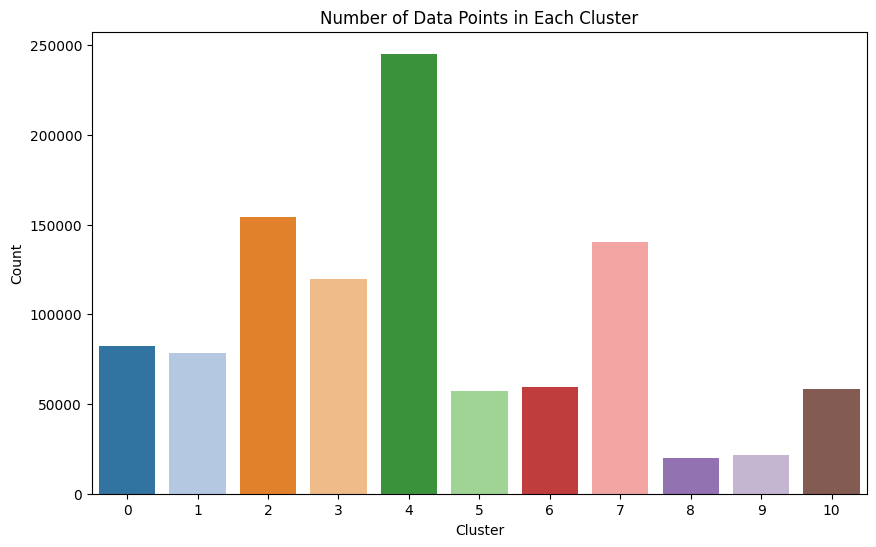

In [8]:
# 1. Distribution of Data Points in Clusters
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='cluster', palette='tab20')
plt.title('Number of Data Points in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.savefig('../images/article_distribution_in_clusters.png')
plt.show()

d:\ML-trend-analysis\Scientific-Trend-Analysis\env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\ML-trend-analysis\Scientific-Trend-Analysis\env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\ML-trend-analysis\Scientific-Trend-Analysis\env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\ML-trend-analysis\Scientific-Trend-Analysis\env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

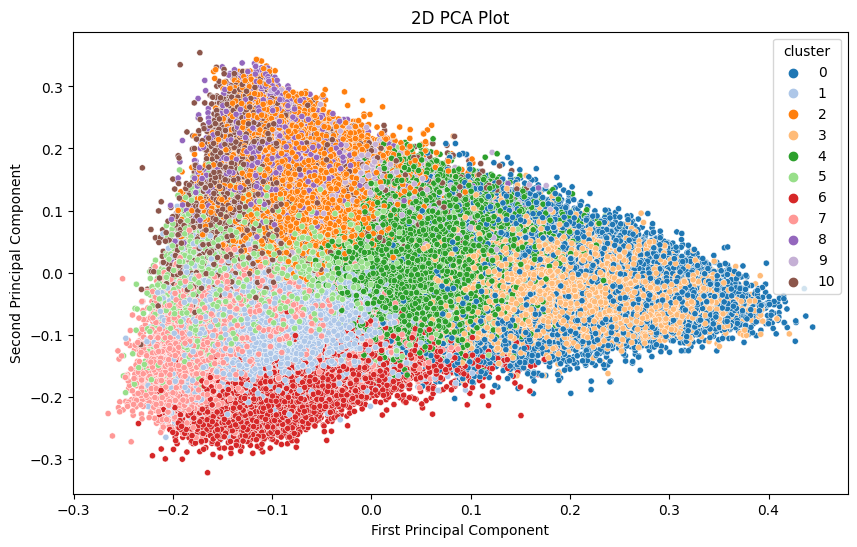

In [9]:
# 2. PCA Plot (2D)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_matrix[:, 0], y=pca_matrix[:, 1], hue=df['cluster'], palette='tab20', s=20)
plt.title('2D PCA Plot')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.savefig('../images/pca_plot_2D.png')
plt.show()

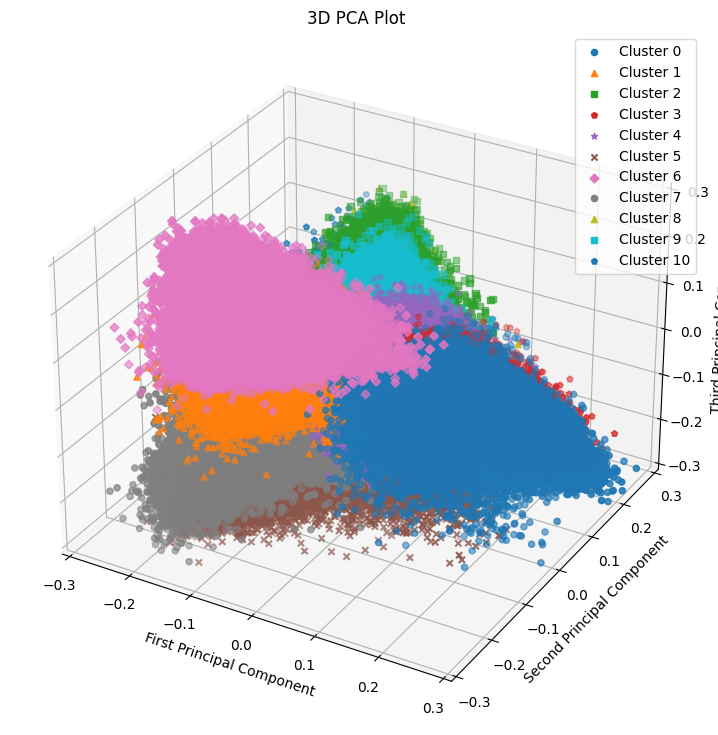

In [19]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Initialize a 3D plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Number of clusters
n_clusters = np.max(df['cluster']) + 1  # cluster numbers start from 0

# Different marker styles
markers = ['o', '^', 's', 'p', '*', 'x', 'D']

# Scatter plot with legends
for i in range(n_clusters):
    subset = pca_matrix[df['cluster'] == i]
    ax.scatter(subset[:, 0], subset[:, 1], subset[:, 2], label=f'Cluster {i}', marker=markers[i % len(markers)])

# To zoom in
ax.set_xlim([-0.3, 0.3])
ax.set_ylim([-0.3, 0.3])
ax.set_zlim([-0.3, 0.3])

# Add labels and title
ax.set_title('3D PCA Plot')
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_zlabel('Third Principal Component')

# Add a legend to indicate cluster numbers
ax.legend()

plt.show()


## Save Results

In [11]:
output_file = '../data/data_clustered.csv'
df.to_csv(output_file, index=False)